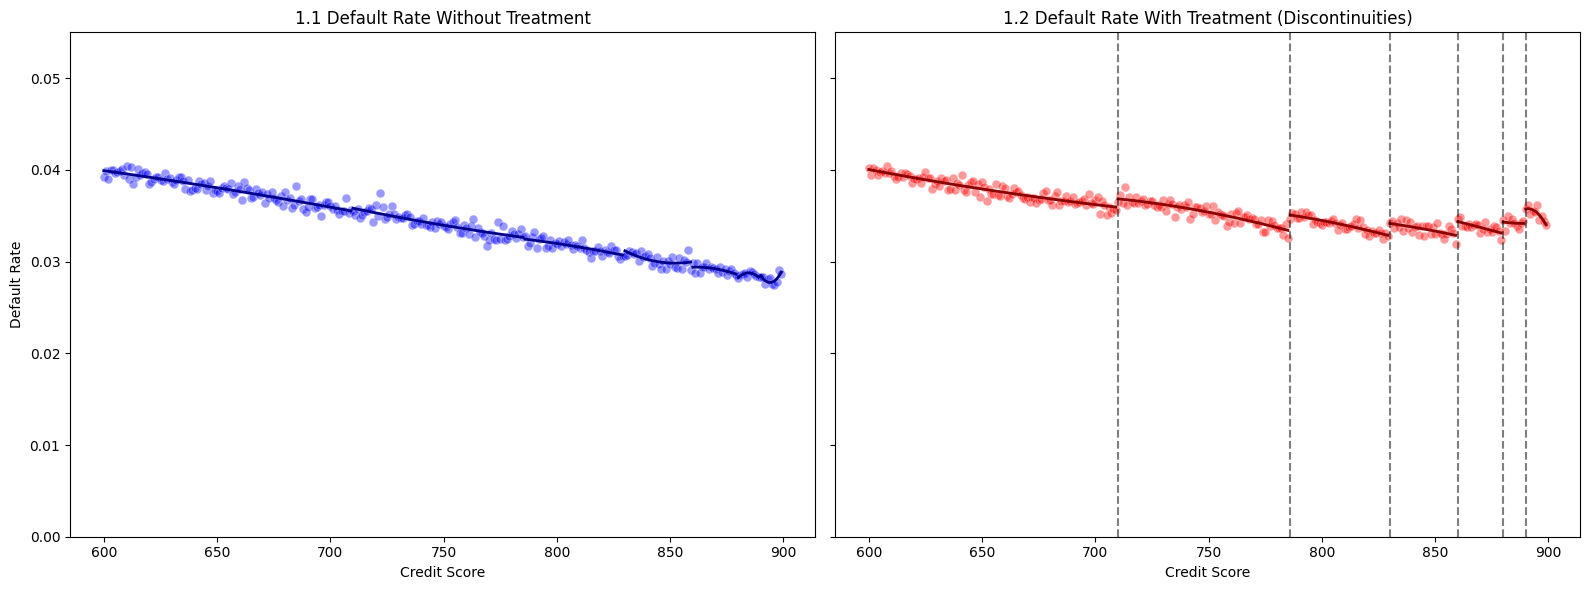

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
from scipy.interpolate import make_interp_spline

# Set random seed
np.random.seed(55)

# --- Setup parameters ---
scores = np.arange(600, 900)
thresholds = [710, 786, 830, 860, 880, 890]
cutoffs = [600] + thresholds + [900]

# --- Non-treatment data (natural decline) ---
base_rate_non = 0.4 - 0.0004 * (scores - 600)
noise_non = np.random.normal(0, 0.005, len(scores))
default_rate_nontreatment = np.clip((base_rate_non + noise_non) / 10, 0.01, 0.05)
df_nontreatment = pd.DataFrame({'CreditScore': scores, 'DefaultRate': default_rate_nontreatment})

# --- Treatment data (jumps + steep decline) ---
base_rate_treat = 0.4 - 0.0004 * (scores - 600)
noise_treat = np.random.normal(0, 0.005, len(scores))
adjusted_rate = base_rate_treat + noise_treat

# Inject jumps and steepen slope
slope_adjustment = 0.00005
for threshold in thresholds:
    idx = np.where(scores >= threshold)[0]
    adjusted_rate[idx] += 0.015
    adjusted_rate[idx] -= slope_adjustment * (scores[idx] - threshold)

default_rate_treatment = np.clip(adjusted_rate / 10, 0.01, 0.05)
df_treatment = pd.DataFrame({'CreditScore': scores, 'DefaultRate': default_rate_treatment})

# --- Segment both datasets ---
def segment_df(df, cutoffs):
    segments = []
    for i in range(len(cutoffs) - 1):
        mask = (df['CreditScore'] >= cutoffs[i]) & (df['CreditScore'] < cutoffs[i+1])
        segments.append(df[mask].copy())
    return segments

segments_nontreated = segment_df(df_nontreatment, cutoffs)
segments_treated = segment_df(df_treatment, cutoffs)

# --- Plot ---
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# -- Plot Non-treatment --
sns.scatterplot(x='CreditScore', y='DefaultRate', data=df_nontreatment, ax=axs[0],
                color='blue', alpha=0.4, s=40)

for seg in segments_nontreated:
    if len(seg) < 5: continue
    x_seg = seg['CreditScore']
    y_seg = seg['DefaultRate']
    logit_y = np.log(y_seg / (1 - y_seg))
    coef = np.polyfit(x_seg, logit_y, 2)
    x_vals = np.linspace(x_seg.min(), x_seg.max(), 50)
    y_vals = expit(np.polyval(coef, x_vals))
    spline = make_interp_spline(x_vals, y_vals, k=3)
    axs[0].plot(x_vals, y_vals, linewidth=2, color='darkblue')

axs[0].set_title('1.1 Default Rate Without Treatment')
axs[0].set_ylabel('Default Rate')
axs[0].set_xlabel('Credit Score')
axs[0].set_ylim(0, 0.055)

# -- Plot Treatment --
sns.scatterplot(x='CreditScore', y='DefaultRate', data=df_treatment, ax=axs[1],
                color='red', alpha=0.4, s=40)

for seg in segments_treated:
    if len(seg) < 5: continue
    x_seg = seg['CreditScore']
    y_seg = seg['DefaultRate']
    logit_y = np.log(y_seg / (1 - y_seg))
    coef = np.polyfit(x_seg, logit_y, 2)
    x_vals = np.linspace(x_seg.min(), x_seg.max(), 50)
    y_vals = expit(np.polyval(coef, x_vals))
    spline = make_interp_spline(x_vals, y_vals, k=3)
    axs[1].plot(x_vals, y_vals, linewidth=2, color='darkred')

for cutoff in thresholds:
    axs[1].axvline(x=cutoff, linestyle='--', color='black', alpha=0.5)

axs[1].set_title('1.2 Default Rate With Treatment (Discontinuities)')
axs[1].set_xlabel('Credit Score')

plt.tight_layout()
plt.show()


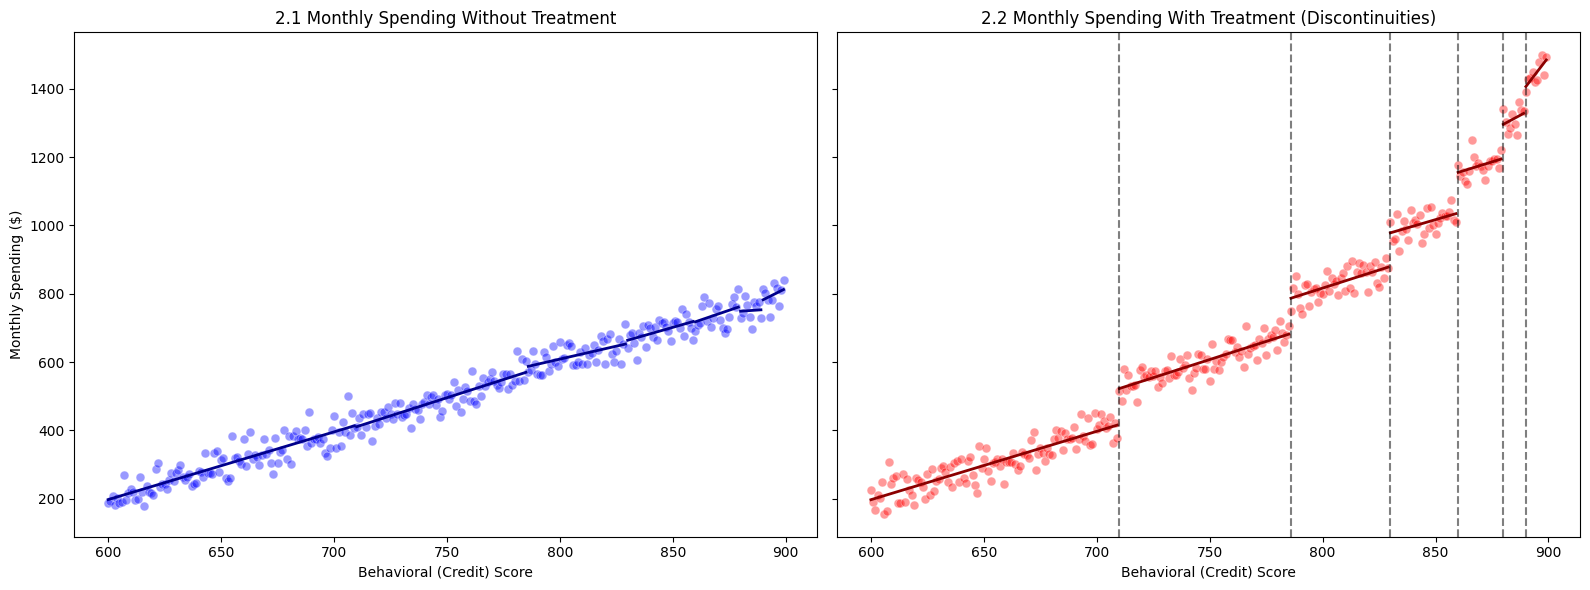

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed
np.random.seed(31)

# --- Setup parameters ---
scores = np.arange(600, 900)
thresholds = [710, 786, 830, 860, 880, 890]
cutoffs = [600] + thresholds + [900]

# --- Non-treatment spending (upward sloping) ---
base_spend_non = 200 + 2 * (scores - 600)
noise_non = np.random.normal(0, 30, len(scores))
spending_nontreatment = np.clip(base_spend_non + noise_non, 0, None)
df_nontreatment = pd.DataFrame({'CreditScore': scores, 'Spending': spending_nontreatment})

# --- Treatment spending (jumps + slope increase) ---
base_spend_treat = 200 + 2 * (scores - 600)
noise_treat = np.random.normal(0, 30, len(scores))
adjusted_spend = base_spend_treat + noise_treat

slope_boost = 0.1
for threshold in thresholds:
    idx = np.where(scores >= threshold)[0]
    adjusted_spend[idx] += 100
    adjusted_spend[idx] += slope_boost * (scores[idx] - threshold)

spending_treatment = np.clip(adjusted_spend, 0, None)
df_treatment = pd.DataFrame({'CreditScore': scores, 'Spending': spending_treatment})

# --- Segmenting function ---
def segment_df(df, cutoffs):
    segments = []
    for i in range(len(cutoffs) - 1):
        mask = (df['CreditScore'] >= cutoffs[i]) & (df['CreditScore'] < cutoffs[i+1])
        segments.append(df[mask].copy())
    return segments

segments_nontreated = segment_df(df_nontreatment, cutoffs)
segments_treated = segment_df(df_treatment, cutoffs)

# --- Plot ---
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Non-treatment Plot
sns.scatterplot(x='CreditScore', y='Spending', data=df_nontreatment, ax=axs[0],
                color='blue', alpha=0.4, s=40)
for seg in segments_nontreated:
    if len(seg) < 5: continue
    x_seg = seg['CreditScore']
    y_seg = seg['Spending']
    coef = np.polyfit(x_seg, y_seg, 1)
    x_vals = np.linspace(x_seg.min(), x_seg.max(), 100)
    axs[0].plot(x_vals, np.polyval(coef, x_vals), linewidth=2, color='darkblue')

axs[0].set_title('2.1 Monthly Spending Without Treatment')
axs[0].set_ylabel('Monthly Spending ($)')
axs[0].set_xlabel('Behavioral (Credit) Score')

# Treatment Plot
sns.scatterplot(x='CreditScore', y='Spending', data=df_treatment, ax=axs[1],
                color='red', alpha=0.4, s=40)
for seg in segments_treated:
    if len(seg) < 5: continue
    x_seg = seg['CreditScore']
    y_seg = seg['Spending']
    coef = np.polyfit(x_seg, y_seg, 1)
    x_vals = np.linspace(x_seg.min(), x_seg.max(), 100)
    axs[1].plot(x_vals, np.polyval(coef, x_vals), linewidth=2, color='darkred')

for cutoff in thresholds:
    axs[1].axvline(x=cutoff, linestyle='--', color='black', alpha=0.5)

axs[1].set_title('2.2 Monthly Spending With Treatment (Discontinuities)')
axs[1].set_xlabel('Behavioral (Credit) Score')

plt.tight_layout()
plt.show()


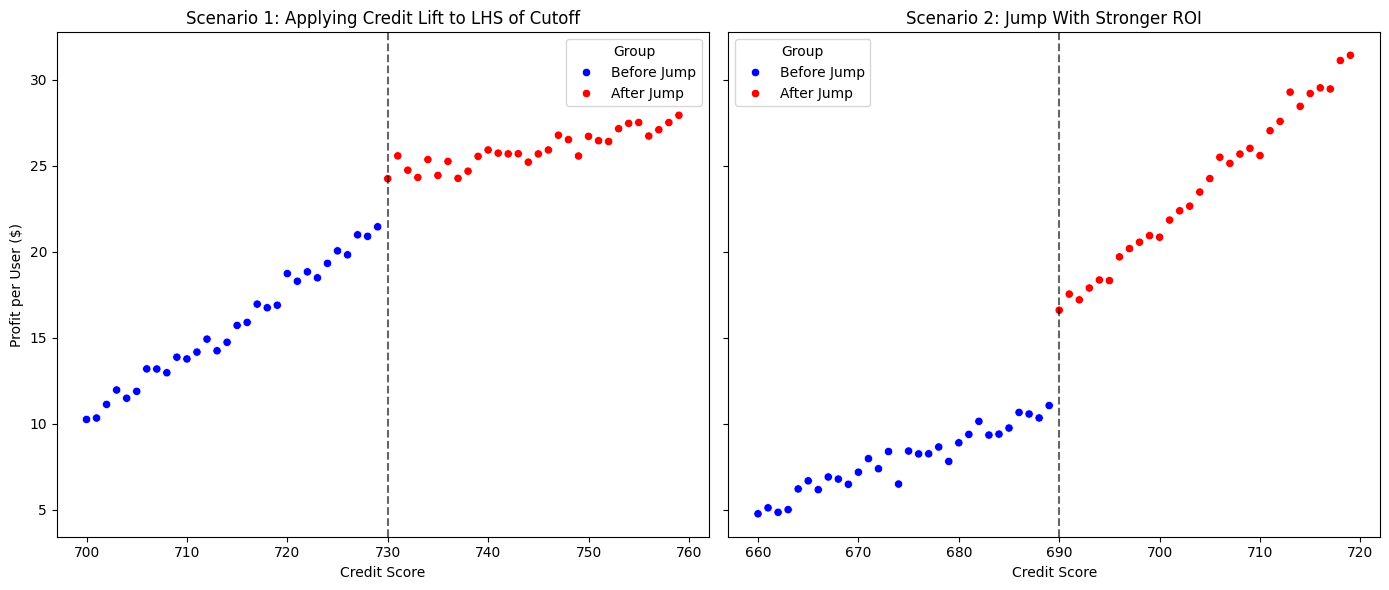

In [21]:
# Re-run necessary imports and setup after kernel reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline

# Set seed for reproducibility
np.random.seed(42)

# Zoomed-in credit score range around a hypothetical cutoff
x1 = np.arange(700, 730)  # Scenario 1: Small slope after jump
x2 = np.arange(660, 690)  # Scenario 2: Bigger slope after jump

# ----- SCENARIO 1: Jump Not Worth It -----
# Left side (pre-treatment): increasing profit
profit_left1 = 10 + 0.4 * (x1 - x1[0]) + np.random.normal(0, 0.5, len(x1))
# Right side (post-treatment): jump + small slope
profit_right1 = profit_left1[-1] + 3 + 0.1 * np.arange(1, len(x1)+1) + np.random.normal(0, 0.5, len(x1))

df1 = pd.DataFrame({
    'CreditScore': np.concatenate([x1, x1 + 30]),  # Simulate break
    'Profit': np.concatenate([profit_left1, profit_right1]),
    'Group': ['Before Jump'] * len(x1) + ['After Jump'] * len(x1)
})

# ----- SCENARIO 2: Jump With Stronger ROI -----
profit_left2 = 5 + 0.2 * (x2 - x2[0]) + np.random.normal(0, 0.5, len(x2))
profit_right2 = profit_left2[-1] + 5 + 0.5 * np.arange(1, len(x2)+1) + np.random.normal(0, 0.5, len(x2))

df2 = pd.DataFrame({
    'CreditScore': np.concatenate([x2, x2 + 30]),
    'Profit': np.concatenate([profit_left2, profit_right2]),
    'Group': ['Before Jump'] * len(x2) + ['After Jump'] * len(x2)
})

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Scenario 1
sns.scatterplot(data=df1, x='CreditScore', y='Profit', hue='Group', palette=['blue', 'red'], ax=axs[0])
axs[0].set_title('Scenario 1: Applying Credit Lift prior to Cutoff')
axs[0].set_ylabel('Profit per User ($)')
axs[0].axvline(x=730, linestyle='--', color='black', alpha=0.6)
axs[0].set_xlabel('Credit Score')

# Scenario 2
sns.scatterplot(data=df2, x='CreditScore', y='Profit', hue='Group', palette=['blue', 'red'], ax=axs[1])
axs[1].set_title('Scenario 2: Jump With Stronger ROI')
axs[1].axvline(x=690, linestyle='--', color='black', alpha=0.6)
axs[1].set_xlabel('Credit Score')

plt.tight_layout()
plt.show()


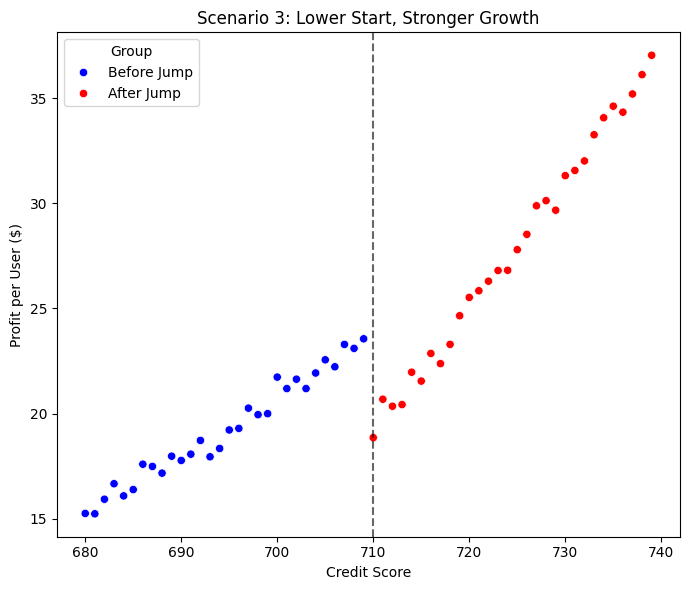

In [22]:
# Adjust Scenario 3 to start the right-hand side even lower
np.random.seed(42)
x3 = np.arange(680, 710)
# Left side: steady growth
profit_left3 = 15 + 0.3 * (x3 - x3[0]) + np.random.normal(0, 0.5, len(x3))
# Right side: larger drop at cutoff, then steep growth
profit_right3 = profit_left3[-1] - 5 + 0.6 * np.arange(1, len(x3)+1) + np.random.normal(0, 0.5, len(x3))

df3_lower = pd.DataFrame({
    'CreditScore': np.concatenate([x3, x3 + 30]),
    'Profit': np.concatenate([profit_left3, profit_right3]),
    'Group': ['Before Jump'] * len(x3) + ['After Jump'] * len(x3)
})

# Plotting adjusted Scenario 3
plt.figure(figsize=(7, 6))
sns.scatterplot(data=df3_lower, x='CreditScore', y='Profit', hue='Group', palette=['blue', 'red'])
plt.axvline(x=710, linestyle='--', color='black', alpha=0.6)
plt.title('Scenario 3: Lower Start, Stronger Growth')
plt.ylabel('Profit per User ($)')
plt.xlabel('Credit Score')
plt.tight_layout()
plt.show()


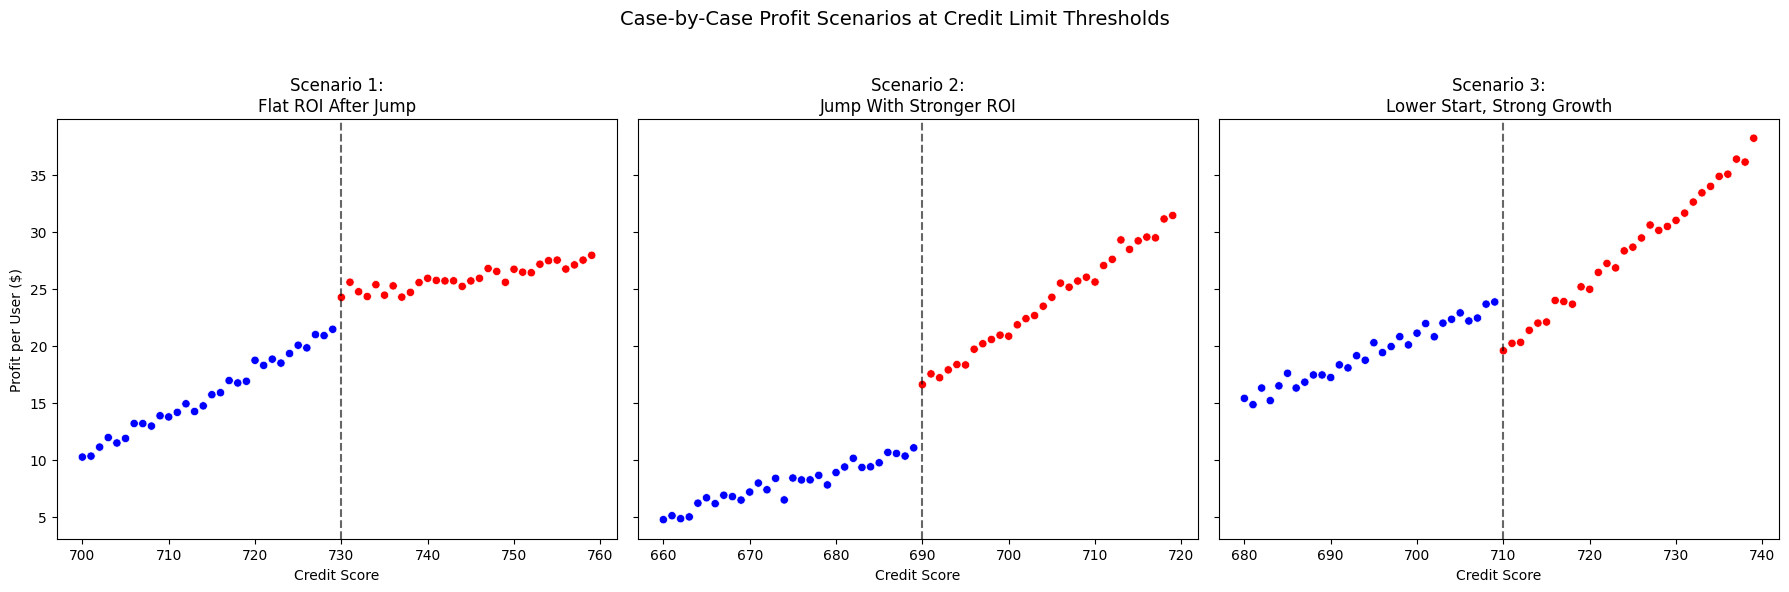

In [23]:
# Recreate all three dataframes since the kernel was reset

# Required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed for reproducibility
np.random.seed(42)

# --- Scenario 1 ---
x1 = np.arange(700, 730)
profit_left1 = 10 + 0.4 * (x1 - x1[0]) + np.random.normal(0, 0.5, len(x1))
profit_right1 = profit_left1[-1] + 3 + 0.1 * np.arange(1, len(x1)+1) + np.random.normal(0, 0.5, len(x1))
df1 = pd.DataFrame({
    'CreditScore': np.concatenate([x1, x1 + 30]),
    'Profit': np.concatenate([profit_left1, profit_right1]),
    'Group': ['Before Jump'] * len(x1) + ['After Jump'] * len(x1)
})

# --- Scenario 2 ---
x2 = np.arange(660, 690)
profit_left2 = 5 + 0.2 * (x2 - x2[0]) + np.random.normal(0, 0.5, len(x2))
profit_right2 = profit_left2[-1] + 5 + 0.5 * np.arange(1, len(x2)+1) + np.random.normal(0, 0.5, len(x2))
df2 = pd.DataFrame({
    'CreditScore': np.concatenate([x2, x2 + 30]),
    'Profit': np.concatenate([profit_left2, profit_right2]),
    'Group': ['Before Jump'] * len(x2) + ['After Jump'] * len(x2)
})

# --- Scenario 3 ---
x3 = np.arange(680, 710)
profit_left3 = 15 + 0.3 * (x3 - x3[0]) + np.random.normal(0, 0.5, len(x3))
profit_right3 = profit_left3[-1] - 5 + 0.6 * np.arange(1, len(x3)+1) + np.random.normal(0, 0.5, len(x3))
df3_lower = pd.DataFrame({
    'CreditScore': np.concatenate([x3, x3 + 30]),
    'Profit': np.concatenate([profit_left3, profit_right3]),
    'Group': ['Before Jump'] * len(x3) + ['After Jump'] * len(x3)
})

# Now plot all three scenarios side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Scenario 1
sns.scatterplot(data=df1, x='CreditScore', y='Profit', hue='Group', palette=['blue', 'red'], ax=axs[0])
axs[0].axvline(x=730, linestyle='--', color='black', alpha=0.6)
axs[0].set_title('Scenario 1:\nFlat ROI After Jump')
axs[0].set_ylabel('Profit per User ($)')
axs[0].set_xlabel('Credit Score')
axs[0].legend().remove()

# Scenario 2
sns.scatterplot(data=df2, x='CreditScore', y='Profit', hue='Group', palette=['blue', 'red'], ax=axs[1])
axs[1].axvline(x=690, linestyle='--', color='black', alpha=0.6)
axs[1].set_title('Scenario 2:\nJump With Stronger ROI')
axs[1].set_xlabel('Credit Score')
axs[1].legend().remove()

# Scenario 3
sns.scatterplot(data=df3_lower, x='CreditScore', y='Profit', hue='Group', palette=['blue', 'red'], ax=axs[2])
axs[2].axvline(x=710, linestyle='--', color='black', alpha=0.6)
axs[2].set_title('Scenario 3:\nLower Start, Strong Growth')
axs[2].set_xlabel('Credit Score')
axs[2].legend().remove()

plt.suptitle('Case-by-Case Profit Scenarios at Credit Limit Thresholds', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
